# Predictive Modeling

## Import Dependencies

In [9]:
import sys
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join('..')))

## Load Modules

In [2]:
from src.data_loader import DataLoader
from src.data_cleaner import DataCleaner
from src.preprocessor import DataPreprocessor
from src.modeling import ModelBuilder

file_path = '../data/raw/MachineLearningRating_v3.txt'

## Load and Clean Data

In [3]:
loader = DataLoader(file_path)
df = loader.load_data()

# Clean using cleaner
cleaner = DataCleaner(df)
df_clean = cleaner.clean_for_models()

# Verify
print(f"Vehicle Age Created? {'VehicleAge' in df_clean.columns}")
print(f"Negative Claims Removed? {df_clean[df_clean['TotalClaims'] < 0].shape[0] == 0}")

INFO:src.data_loader:Data loaded successfully.


Vehicle Age Created? True
Negative Claims Removed? True


## Preprocess the data

In [4]:
# Initialize the Preprocessor
preprocessor = DataPreprocessor(df_clean)

# Prepare for Regression (Predicting Claim Amount for those who crashed)
print("Preparing Data for Severity Prediction...")
X_train, X_test, y_train, y_test = preprocessor.prepare_data(problem_type='regression')

print(f"Training Features Shape: {X_train.shape}")
print(f"Training Target Shape: {y_train.shape}")

Preparing Data for Severity Prediction...
Training Features Shape: (2112, 503)
Training Target Shape: (2112,)


## Model Training and Evaluation

In [6]:
# Initialize Builder 
builder = ModelBuilder(X_train, X_test, y_train, y_test)

# Train Models
lr_model = builder.train_linear_regression()
rf_model = builder.train_random_forest()
xgb_model = builder.train_xgboost()

# Evaluate
results_df = builder.evaluate_models()
display(results_df)

Training Linear Regression...
Training Random Forest (this may take time)...
Training XGBoost...

--- Model Evaluation ---
LinearRegression -> RMSE: 331237165.22, R2: -110577522.4237
RandomForest -> RMSE: 27900.44, R2: 0.2155
XGBoost -> RMSE: 28744.69, R2: 0.1673


,Model,RMSE,MAE,R2 Score
0,LinearRegression,3.312372e+08,3.070195e+07,-1.105775e+08
1,RandomForest,2.790044e+04,1.413727e+04,2.154675e-01
2,XGBoost,2.874469e+04,1.422966e+04,1.672702e-01


## Feature Importance

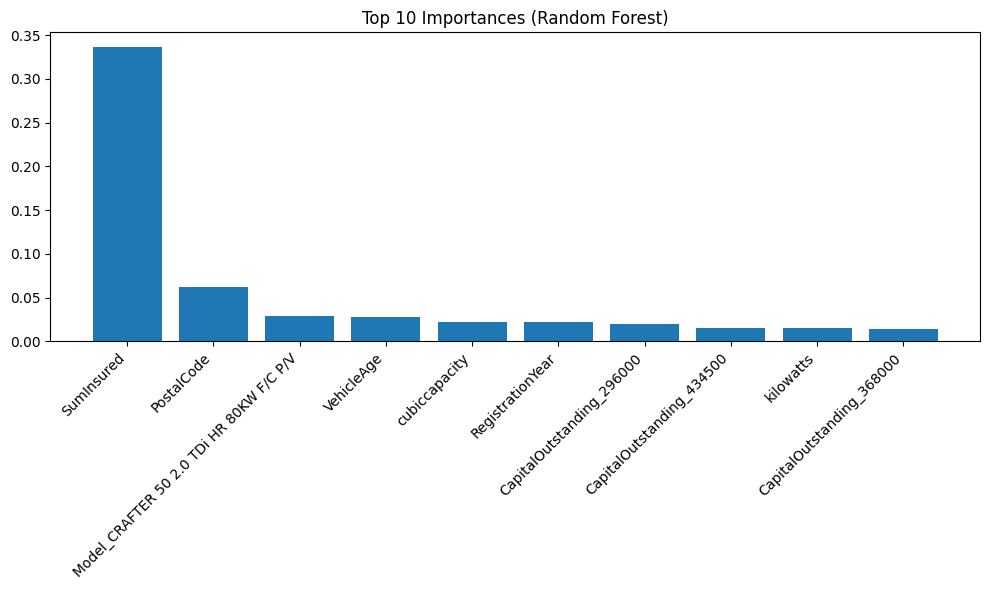

In [7]:
# Get Feature names
feature_names = preprocessor.feature_names

# Plot Random forest Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10,6))
plt.title("Top 10 Importances (Random Forest)")
plt.bar(range(10), importances[indices], align='center')
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

## SHAP Analysis

PermutationExplainer explainer: 530it [01:10,  6.55it/s]                         


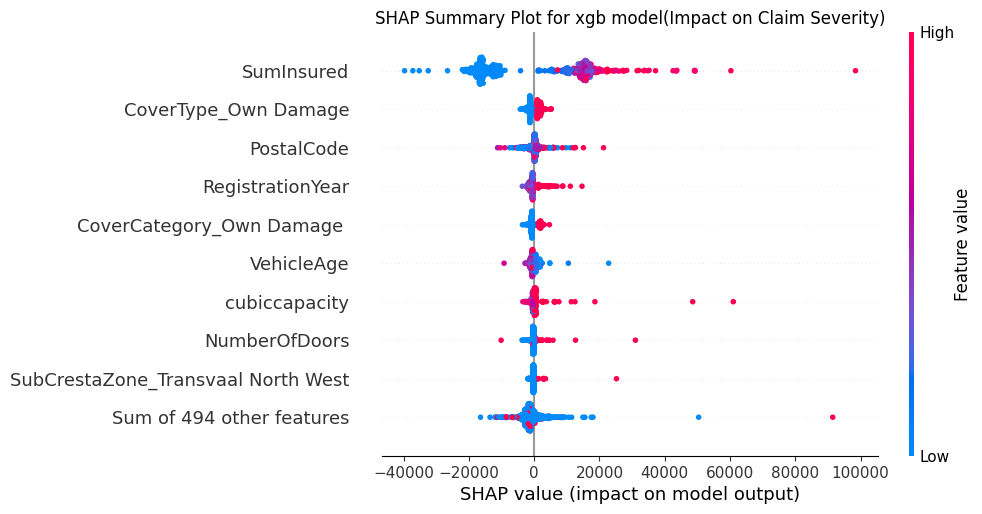

In [16]:
# Use XGBoost for SHAP (it's faster and well-supported)
feature_names = preprocessor.feature_names
explainer = shap.Explainer(xgb_model.predict, X_test)
shap_values = explainer(pd.DataFrame(X_test, columns=feature_names))

# Beeswarm Plot
plt.title("SHAP Summary Plot for xgb model(Impact on Claim Severity)")
shap.plots.beeswarm(shap_values, max_display=10)

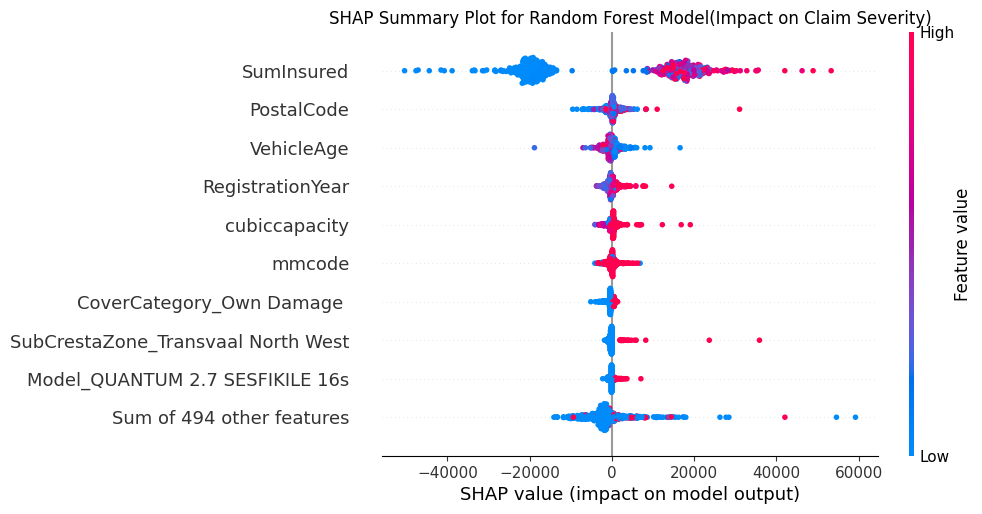

In [17]:
feature_names = preprocessor.feature_names
explainer = shap.Explainer(rf_model)
shap_values = explainer(pd.DataFrame(X_test, columns=feature_names))

# Beeswarm Plot
plt.title("SHAP Summary Plot for Random Forest Model(Impact on Claim Severity)")
shap.plots.beeswarm(shap_values, max_display=10)